# Description: AllLife Bank Customer Segmentation
## Context:
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. <span class="mark">Another insight from the market research was that the customers perceive the support services of the bank poorly</span>. Based on this, the Operations team wants to <span class="mark">upgrade the service delivery model, to ensure that customers' queries are resolved faster</span>. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

## Objective: 
To identify different segments in the existing customer based on their <span class="mark">spending patterns</span> as well as <span class="mark">past interactions</span> with the bank.

# Dataset
## Data Description: 
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call center.

# Questions
* How many clusters are formed from the data?
* How are the reultant segments different from each other?
* What are the recommendations on how to better market to and service the customers?

# Data import and overview
## Import libraries

In [30]:
#importing necessary libraries
import pandas as pd
import numpy as np

#importing visualization libraries
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

#Modeling tools
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from scipy.stats import zscore

# Library to suppress the warning
import warnings
warnings.filterwarnings('ignore')



## Read data

In [31]:
data=pd.read_excel('Credit Card Customer Data.xlsx')
df = data.copy()

## Explore: Head/tail, Clean, Nunique, Info, Shape, Describe, isNa, Duplicated

In [32]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [33]:
df.rename(columns = {'Customer Key':'Customer_Key'}, inplace = True)
df.head()

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [34]:
#dropping the serial no. column as it does not hold any statistical significance
df.drop('Sl_No',axis=1,inplace=True)
df.drop('Customer_Key', axis=1, inplace=True)

In [35]:
df.nunique()

Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


* All data is in numeric format

In [37]:
df.shape

(660, 5)

* There are 600 rows and 5 columns

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


* There are no missing values
* The average credit limit is \\$34,574 with a max amount of $200,000
* The maximum number of credit cards owned is 10, with the average being around 5
* The most a customer visited a bank was 5 times; there were some customers who never visited the bank
* The maximum online queries was 15
* The most number of calls was 10, with an average of 3.6 in the time period

In [39]:
df.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

* There are no missing values

In [40]:
df.duplicated().sum()

11

In [41]:
df.loc[df.duplicated(keep=False), :]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
17,8000,2,0,3,4
29,8000,4,0,4,7
56,6000,1,0,2,5
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
250,18000,6,3,1,4
252,9000,4,5,0,4
257,10000,6,4,2,3
295,10000,6,4,2,3


In [42]:
df.shape

(660, 5)

* There are 11 duplicates.  We will see what we will need to do with them in analysis

# EDA
## Univariate Analysis
### Boxplot

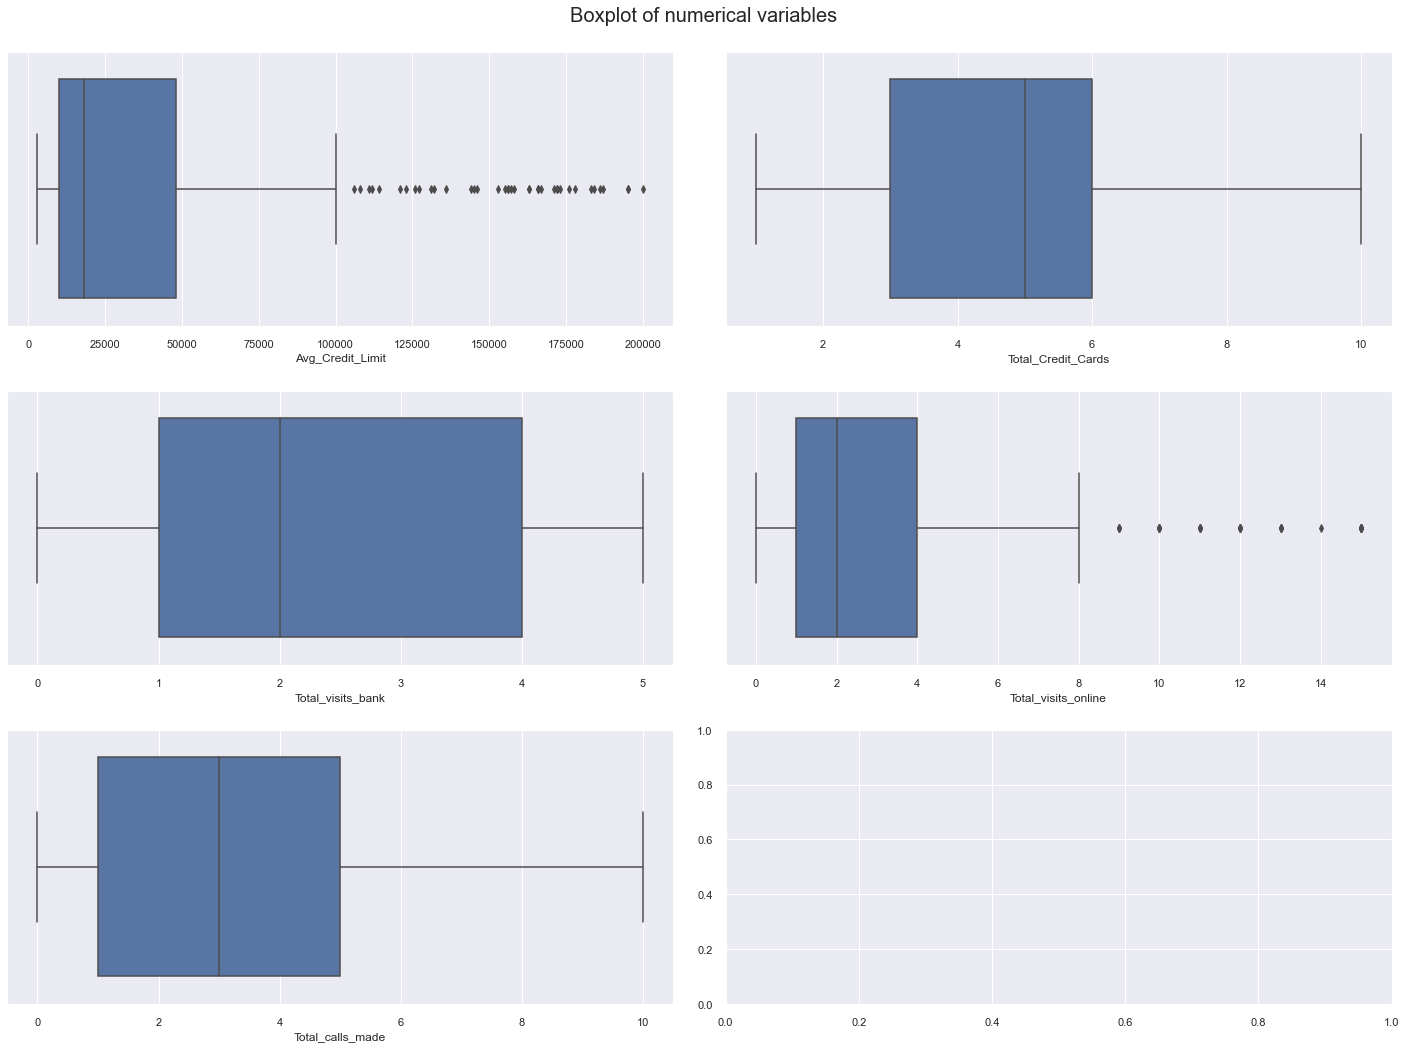

In [43]:
# selecting numerical columns
all_col = df.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(3, 2,  figsize=(20, 15))
fig.suptitle('Boxplot of numerical variables', fontsize=20)
counter = 0
for ii in range(3):
    sns.boxplot(ax=axes[ii][0],x=df[all_col[counter]])
    counter = counter+1
    if counter != 5:
        sns.boxplot(ax=axes[ii][1],x=df[all_col[counter]])
        counter = counter+1
    else:
        pass

fig.tight_layout(pad=2.0)

* There are considerable outliers to the right of the credit limit boxplot. The mean and median are well below 50,000. However, depending on customers income and background, it is possible that a/some customer/s could have achieved a level of financial strength to be given such a high limit.  This is also considering the other numerous outlier values outside of the max
* There are no outliers in credit cards, bank visits, or calls made
* There are outliers to the right in the number of online visits. These will not be deleted as it is a real-world possibility to have that many visits online

### Histogram

In [44]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency 
# and dispersion.
# Let us write a function that will help us create a boxplot and histogram for any input numerical 
# variable.
# This function takes the numerical column as the input and returns the boxplots 
# and histograms for the variable.
# Let us see if this helps us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(10,7), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='red') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,color = 'orange') if bins else sns.distplot(feature, kde=False, ax=ax_hist2,color='tab:cyan') # For histogram
    ax_hist2.axvline(np.mean(feature), color='purple', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

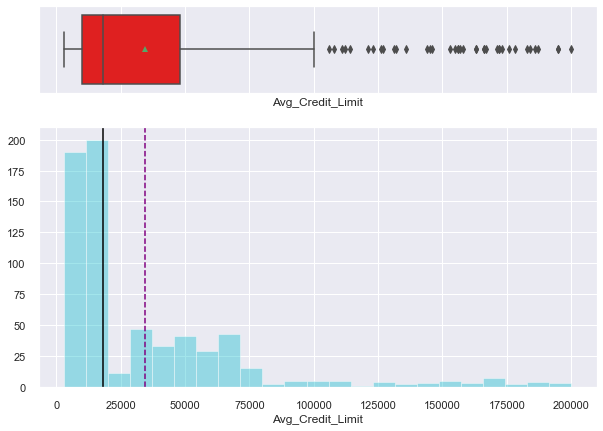

In [45]:
histogram_boxplot(df.Avg_Credit_Limit)

* Right skewed distribution with the mean greater than the median.  
* Considerable number of outliers.  However, due to the frequency and close-knitted-ness, these could be possible values, though probability could be questioned.

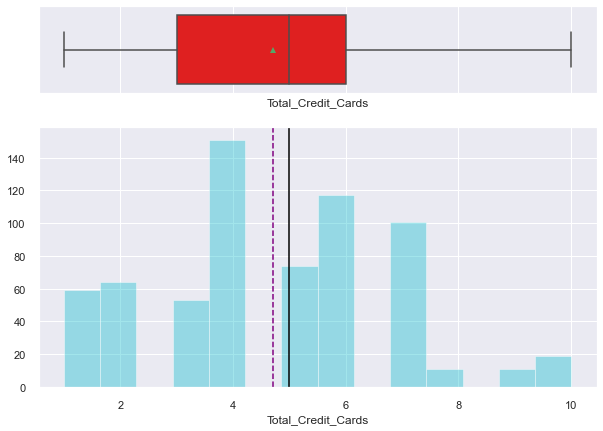

In [46]:
histogram_boxplot(df.Total_Credit_Cards)

* The mean is to the left of the median, which implies a left skew.  However, they are close, so we could interpret this as a somewhat normal distribution
* Mean number of credit cards is close to 5
* There are some people who have a maximum of 10 cards

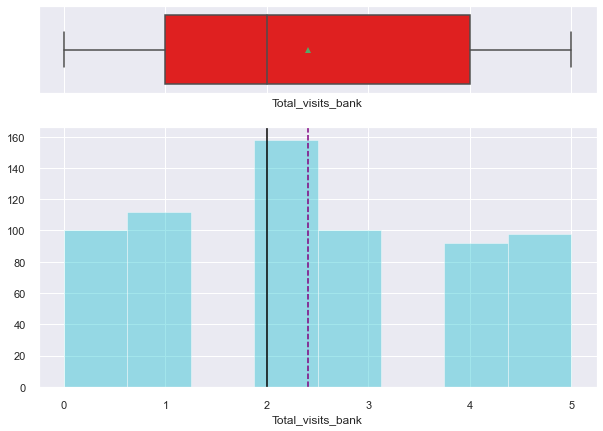

In [47]:
histogram_boxplot(df.Total_visits_bank)

* This would almost appear as a uniform distribution, but there is a peak at value = 2
* The mean is about 2.5

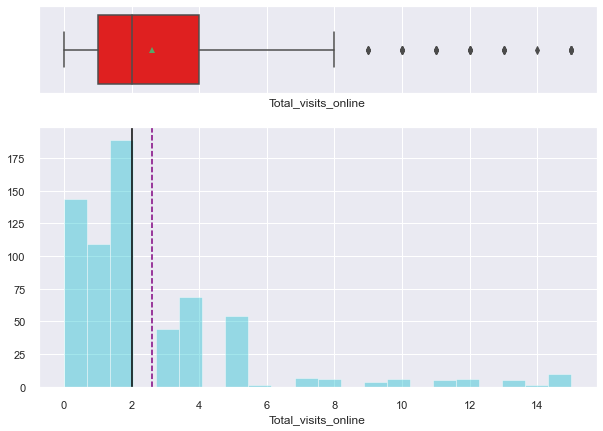

In [48]:
histogram_boxplot(df.Total_visits_online)

* The mean of this distribution is close to 3
* There are a few outliers to the right of the distribution, but can be realistic values as to the number of visits to the online portal of the bank
* Most of the visits number between 0 and 2

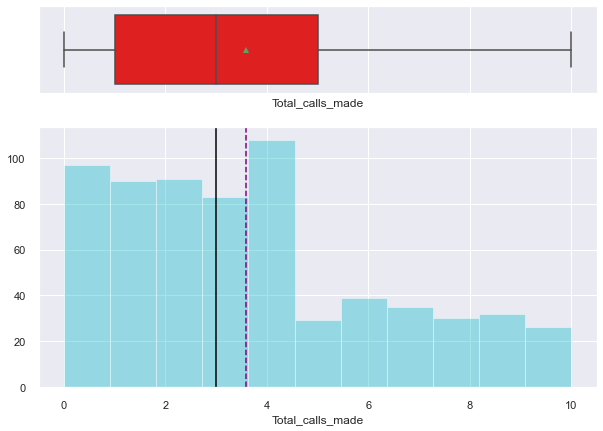

In [49]:
histogram_boxplot(df.Total_calls_made)

* The mean of the distribution is close to 4, with the median closer to 3, indicating a small right skew
* Close to 75% of the customers made fewer than 4 calls
* The max number of calls recorded is 10

### Insights
* The average credit limit is heavily skewed to the right, with most customers having a very small limit
* The total number of cards is somewhat normally distributed, with the mean slightly to the left of the median
* Total bank visits is normal and this appears to be the preferred method the customers have when interacting with the bank
* Online visits is skewed to the right. This does not appear to be a preferred method to communicate with the bank
* Total calls made is skewed to the right. After 4 calls, people do not seem to support this method of interaction

### CDF Plot of numerical values

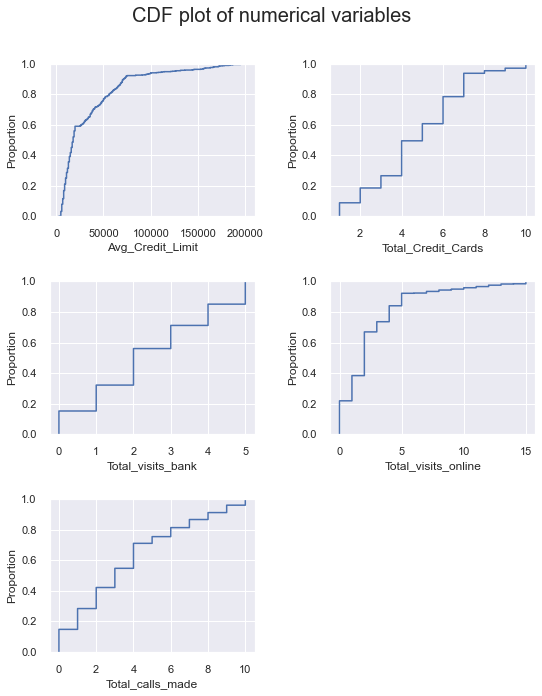

In [50]:
# select numerical columns
all_col = df.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(3, 2,  figsize=(8, 10))
fig.suptitle('CDF plot of numerical variables', fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0],x=df[all_col[counter]])
    counter = counter+1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1],x=df[all_col[counter]])
        counter = counter+1
    else:
        pass

fig.delaxes(ax= axes[2,-1]) 
    
fig.tight_layout(pad=2.0)

* 90% of the customers have credit limits below $75,000
* 80% of the customers have 6 cards or fewer
* 80% of the customers visited the bank no more than 4 times
* 90% of the customers online interacted online 5 times or fewer
* 70% of the customers interacted through the phone 4 times or less

## Bivariate analysis
### Heatmap

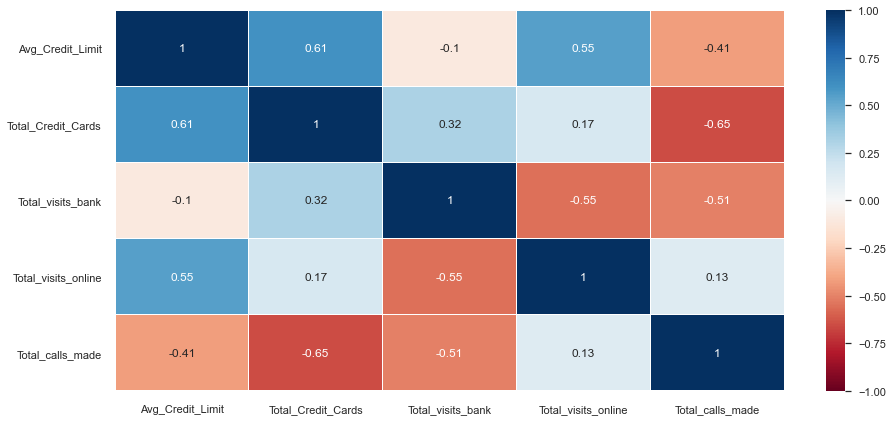

In [51]:
plt.figure(figsize=(15,7))

sns.heatmap(df[all_col].corr(),
            annot=True,
            linewidths=0.5,vmin=-1,vmax=1,
            center=0,
            cbar=True,
           cmap='RdBu')

plt.show()

* There is a strong correlation between Credit Limit and Credit Cards
* There is a strong negative correlation between Credit Cards and Calls Made
* There is a moderately strong negative correlation between Online and Bank Visits, as well Calls Made and Bank Visits
* Total calls appears to have a negative correlation with all other features except for online visits

### Pairplot

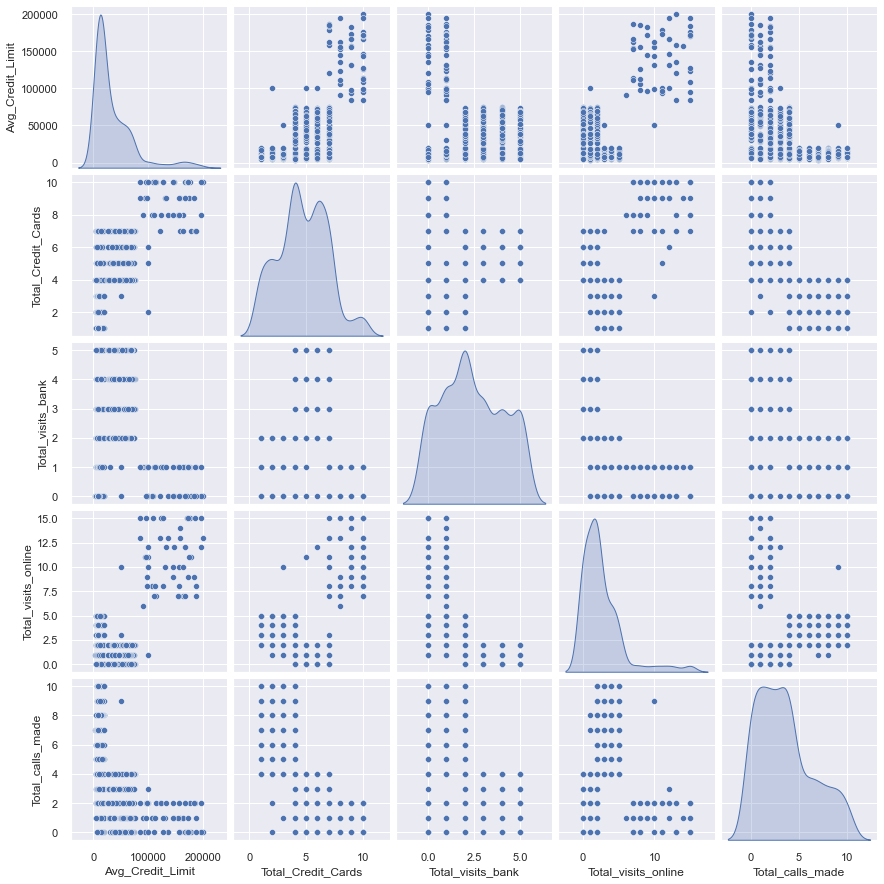

In [52]:
sns.pairplot(df[all_col],diag_kind="kde")

### Boxplot

<AxesSubplot:xlabel='Total_Credit_Cards', ylabel='Avg_Credit_Limit'>

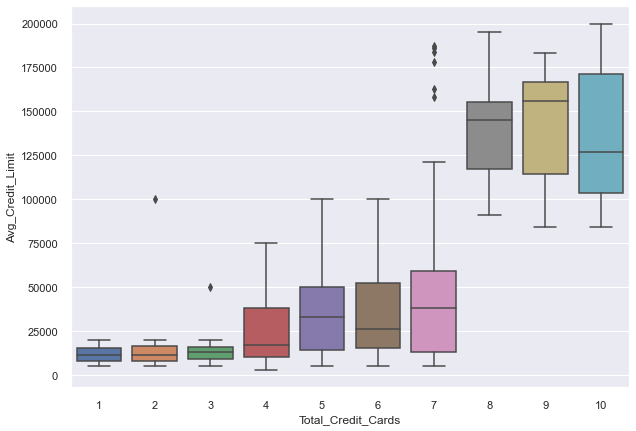

In [53]:
plt.figure(figsize=(10,7))
sns.boxplot(df['Total_Credit_Cards'], df['Avg_Credit_Limit'])

* It makes sense that the more credit cards owned, that the credit limit would be higher
* Those with at most 3 cards will not see a credit limit increase until they reach 4 cards
* There is a large jump in credit limit once the number of cards reaches 8

<AxesSubplot:xlabel='Total_visits_online', ylabel='Avg_Credit_Limit'>

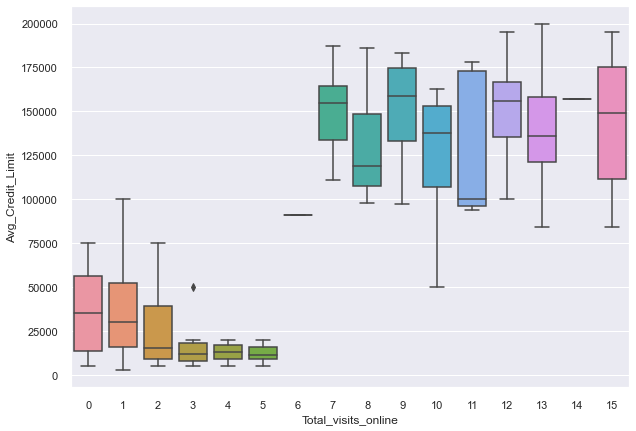

In [54]:
plt.figure(figsize=(10,7))
sns.boxplot(df['Total_visits_online'], df['Avg_Credit_Limit'])

* There is a brief negative correlation between credit limit and online visits up until the 6th visit.  Immediately, there is a large increase in the number of visits after 6, and it holds steady
* At this point, we could begin to suggest that there seems to be a need for online queries among those with credit limits above 100000K

<AxesSubplot:xlabel='Total_visits_online', ylabel='Total_visits_bank'>

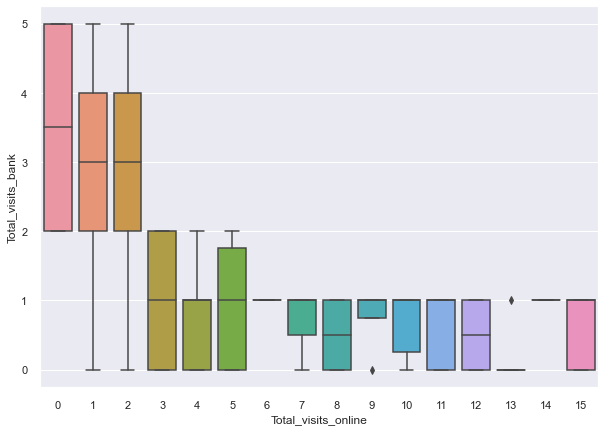

In [55]:
plt.figure(figsize=(10,7))
sns.boxplot(df['Total_visits_online'], df['Total_visits_bank'])

* It would appear that customers would prefer one method over another when communicating with the bank.  Here, those that visited the bank the most did not use the online method much.  Conversely, when the customer used the online method more, they did not visit the bank in person.  This is due to the circumstance of convenience.

<AxesSubplot:xlabel='Total_calls_made', ylabel='Total_visits_bank'>

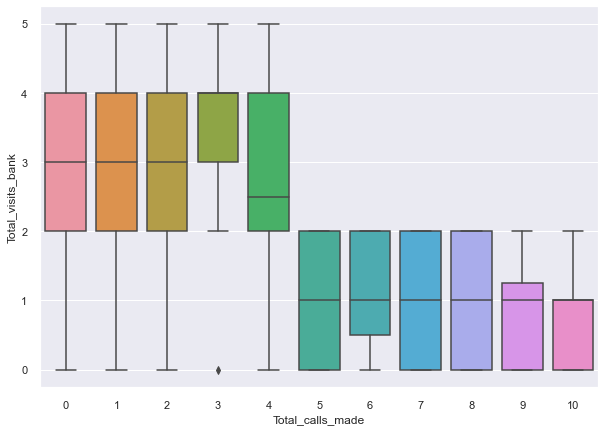

In [56]:
plt.figure(figsize=(10,7))
sns.boxplot(df['Total_calls_made'], df['Total_visits_bank'])

* It would appear that customers would prefer one method over another when communicating with the bank.  Here, those that visited the bank the most did not use the calls method much.  Conversely, when the customer used the calls method more, they did not visit the bank in person.  This is due to the circumstance of convenience.

<AxesSubplot:xlabel='Total_Credit_Cards', ylabel='Total_calls_made'>

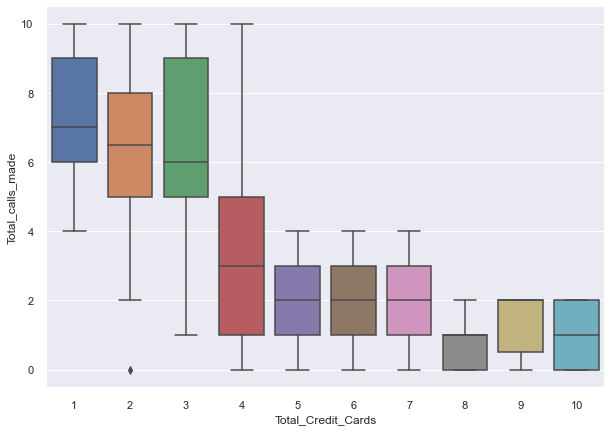

In [57]:
plt.figure(figsize=(10,7))
sns.boxplot(df['Total_Credit_Cards'], df['Total_calls_made'])

* Those that had more than 4 cards made fewer phone queries than those that had fewer than 4

# Preprocessing
## Duplication treatment

In [58]:
df.drop_duplicates(inplace=True)

In [59]:
df.duplicated().sum()

0

## Missing values treatment
* There were no missing values in the dataset

## Outlier treatment

* After reviewing the outliers in the variables, I have determined that these might not be anomalies, but could actually be real-world instances.  As such, they will not be removed for analysis

## Scaling the data using StandardScalar

In [60]:
# Scaling the data set before clustering and assign to new object
scaler=StandardScaler() #Instantiate the StandardScalar class and assign to object "scaler"
subset=df[all_col].copy() #Copy original dataset (df) and assign to name "subset"
subset_scaled=scaler.fit_transform(subset)   #fit_transform "subset" and save as "subset_scaled"

In [61]:
#Creating a dataframe from the scaled data above
subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)

In [62]:
subset_scaled_df.columns #check the columns of the new dataframe

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

# Clustering
## K-means clustering application

In [63]:
#Assign variabless to be used in loop
clusters=range(1,9)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k) #Instantiate
    model.fit(subset_scaled_df) #Fit
    prediction=model.predict(subset_scaled_df) #Predict
    distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0]
                           
    meanDistortions.append(distortion) #Append

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

# plt.plot(clusters, meanDistortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Average Distortion')
# plt.title('Selecting k with the Elbow Method', fontsize=20)

Number of Clusters: 1 	Average Distortion: 2.007896349270688
Number of Clusters: 2 	Average Distortion: 1.4576197022077821
Number of Clusters: 3 	Average Distortion: 1.1434401208195095
Number of Clusters: 4 	Average Distortion: 1.0435538595477063
Number of Clusters: 5 	Average Distortion: 0.9880591433704322
Number of Clusters: 6 	Average Distortion: 0.9404952836425913
Number of Clusters: 7 	Average Distortion: 0.9073166756375903
Number of Clusters: 8 	Average Distortion: 0.881527204061267


### K selection using Elbow curve

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

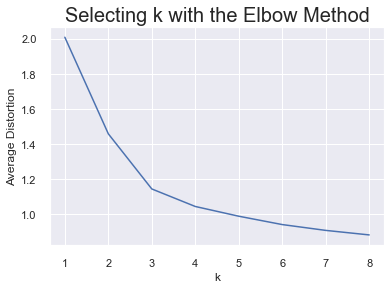

In [64]:
# Plot elbow curve
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20)

* The optimum number of clusters appears to be 3

### K selection using Silhouette score

In [65]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters) #Instantiate
    preds = clusterer.fit_predict((subset_scaled_df)) #fit_predict
    #centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds) #Score
    sil_score.append(score) #Append
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.41800025566689647)
For n_clusters = 3, silhouette score is 0.516281010855363)
For n_clusters = 4, silhouette score is 0.3570238219413198)
For n_clusters = 5, silhouette score is 0.2730908848204728)
For n_clusters = 6, silhouette score is 0.2570412892437478)
For n_clusters = 7, silhouette score is 0.24853158555710844)
For n_clusters = 8, silhouette score is 0.22630013915483066)
For n_clusters = 9, silhouette score is 0.21228509558090097)


* n_cluster = 3 has the highest average silhouette score. So, we will use this number of clusters

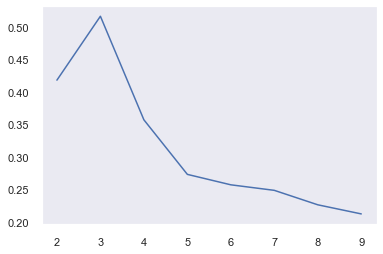

In [66]:
plt.plot(cluster_list,sil_score)
plt.grid()

* Silhouette score is >0.5 at k=3

### Visualization
#### Finding optimal clusters with silhouette coefficients (k = 3, 4, and 5)

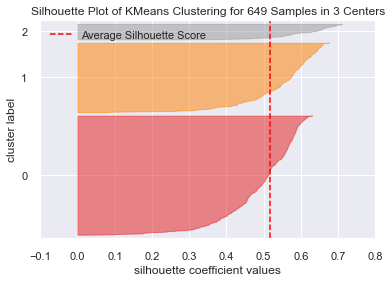

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [67]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show()

* This visualization shows all three clusters surpassing the average silhouette score 0.5
* Cluster two is visually different than the other two
* All clusters are betwee 0.6 and 0.72

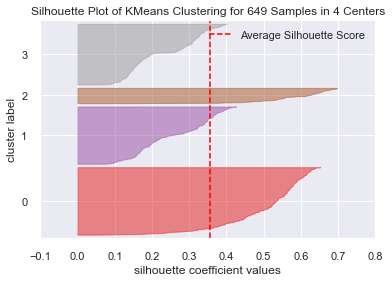

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [68]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show()

* All clusters surpass the average silhouette score, which is lower than k = 3.
* The range of each cluster average varies quite a bit
* Shapes have more variance

* All clusters passed the silhouette score, but there is a lot of variance between the clusters and the average score is lower: between 0.3 and 0.4

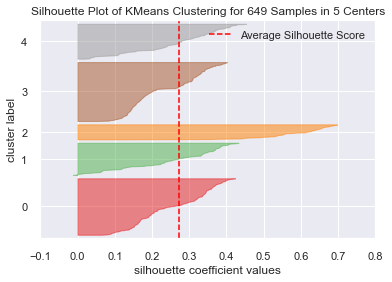

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [69]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show()

* The average silhouette score is sub-0.3
* There is some variance with the shapes and averages
* Cluster 2 does a remarkable job almost reaching 0.7

### Create cluster profile with k = 3

In [70]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=0)

In [71]:
df['K_means_segments'] = kmeans.labels_ #Get the labels after fitting and save as a feature in df
subset_scaled_df['K_means_segments'] = kmeans.labels_ #Save as a feature in subset_scaled_df

In [72]:
cluster_profile = df.groupby('K_means_segments').mean() #Group df by K_means_segments and save to cluster_profile

In [73]:
df.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made', 'K_means_segments'],
      dtype='object')

In [74]:
cluster_profile['count_in_each_segment'] = df.groupby('K_means_segments')['Avg_Credit_Limit'].count().values

In [75]:
# lets display cluster profile highlighting the highest values in column
cluster_profile.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,34071.428571,5.518519,3.484127,0.981481,1.992063,378
1,12239.819005,2.411765,0.945701,3.561086,6.891403,221
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


* Cluster 0 has the highest bank visit count and the lowest online visits count
* Cluster 1 has the highest phone calls made and the lowest credit limit and credit card count
* Cluster 2 has the highest credit limit, card count, and online visits, and the lowest phone calls count
* Cluster 2 has only 50 datapoints

### Scaled Boxplots of numerical values in each cluster

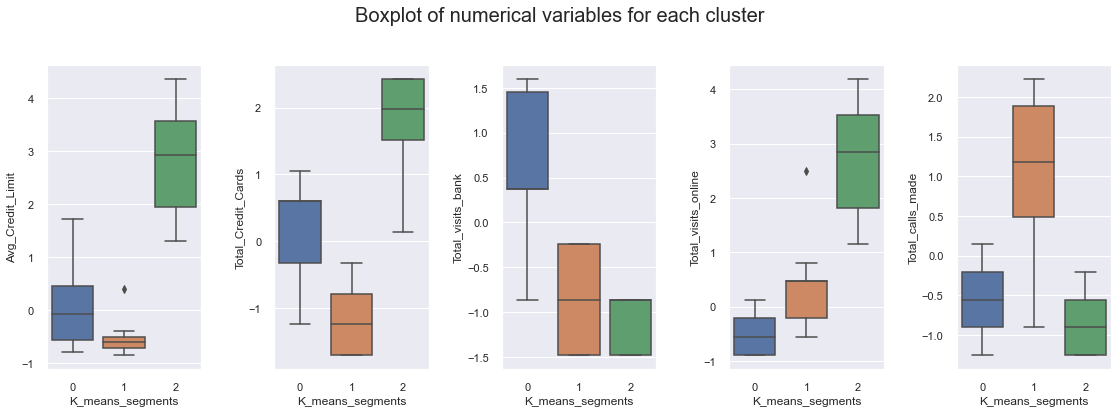

In [76]:
#Y-axis shows scale
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=subset_scaled_df[all_col[counter]],x=subset_scaled_df['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

### Value Boxplots of numerical values in each cluster

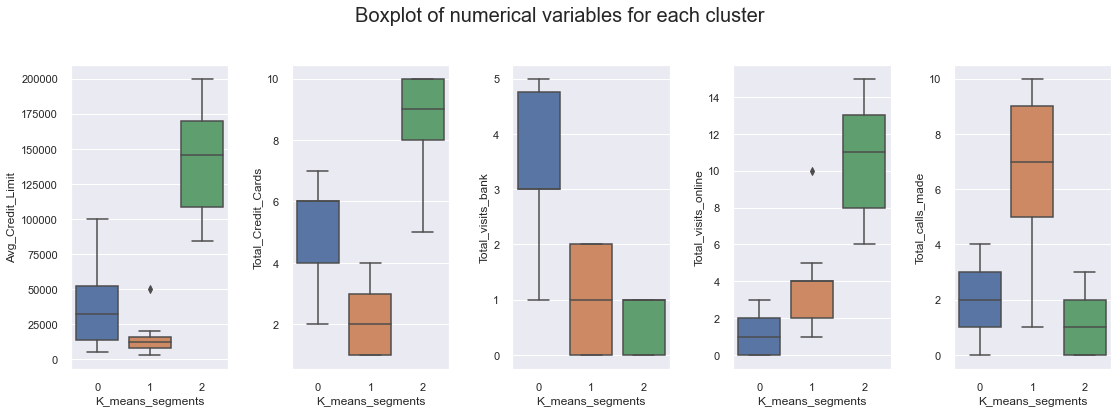

In [77]:
#Y-axis shows actual values
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

### Insights
- **Cluster 0**
   - The average credit limit is on the low end, close to 32K
   - The total number of credit cards is in the middle, around 6
   - This cluster had the highest number of visits (in person) to the bank, between 4 and 5
   - This cluster, consequentially, had low number of online visits and calls made (average of 1 and 2, respectively)

- **Cluster 1**
   - The average credit limit is around 50K, with some customers exceeding the maximum quartile
   - The customers here also have an average of 6 credit cards, but there is a large range from 2 to 10
   - Regarding communication with the institution, the customers here made the 2nd most visits to the bank of around 2.5 times, 
   - A median amount of 1 made online visits
   - A median of 2 made calls, which is the same amount as cluster 0.
   
- **Cluster 2**
   - Highest credit limit
   - Highest number of credit cards
   - On average, 1 visit to the bank in a specified time frame
   - Highest online visits
   



## Hierarchical 
### Dataset overview

In [78]:
df2  = data.copy()

In [79]:
df2.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [80]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [81]:
df2.drop(['Sl_No'], axis=1, inplace=True)
df2.drop(['Customer Key'], axis=1, inplace=True)

#### Standardize the data

In [82]:
sc = StandardScaler()
subset_scaled_df2 = pd.DataFrame(sc.fit_transform(df2),columns=df2.columns)
subset_scaled_df2.head()
subset_scaled_df2.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


### Cophenetic correlation

In [83]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
linkage_methods = ['single', 'complete', 'average', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df2, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(subset_scaled_df2))
        print('Cophent correlation for distance metrics= {}, and linkage method= {} is {}'.format(dm,lm,c))
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm
            
            



Cophent correlation for distance metrics= euclidean, and linkage method= single is 0.7391220243806552
Cophent correlation for distance metrics= euclidean, and linkage method= complete is 0.8599730607972423
Cophent correlation for distance metrics= euclidean, and linkage method= average is 0.8977080867389372
Cophent correlation for distance metrics= euclidean, and linkage method= weighted is 0.8861746814895477
Cophent correlation for distance metrics= chebyshev, and linkage method= single is 0.7382354769296767
Cophent correlation for distance metrics= chebyshev, and linkage method= complete is 0.8533474836336782
Cophent correlation for distance metrics= chebyshev, and linkage method= average is 0.8974159511838106
Cophent correlation for distance metrics= chebyshev, and linkage method= weighted is 0.8913624010768603
Cophent correlation for distance metrics= mahalanobis, and linkage method= single is 0.7058064784553606
Cophent correlation for distance metrics= mahalanobis, and linkage met

In [84]:
print('Highest cophenet correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))

Highest cophenet correlation is 0.8977080867389372, which is obtinaed with euclidean distance metric and average linkage method


### Create dendrograms utilizing truncate_mode/p=7 for easier visualization

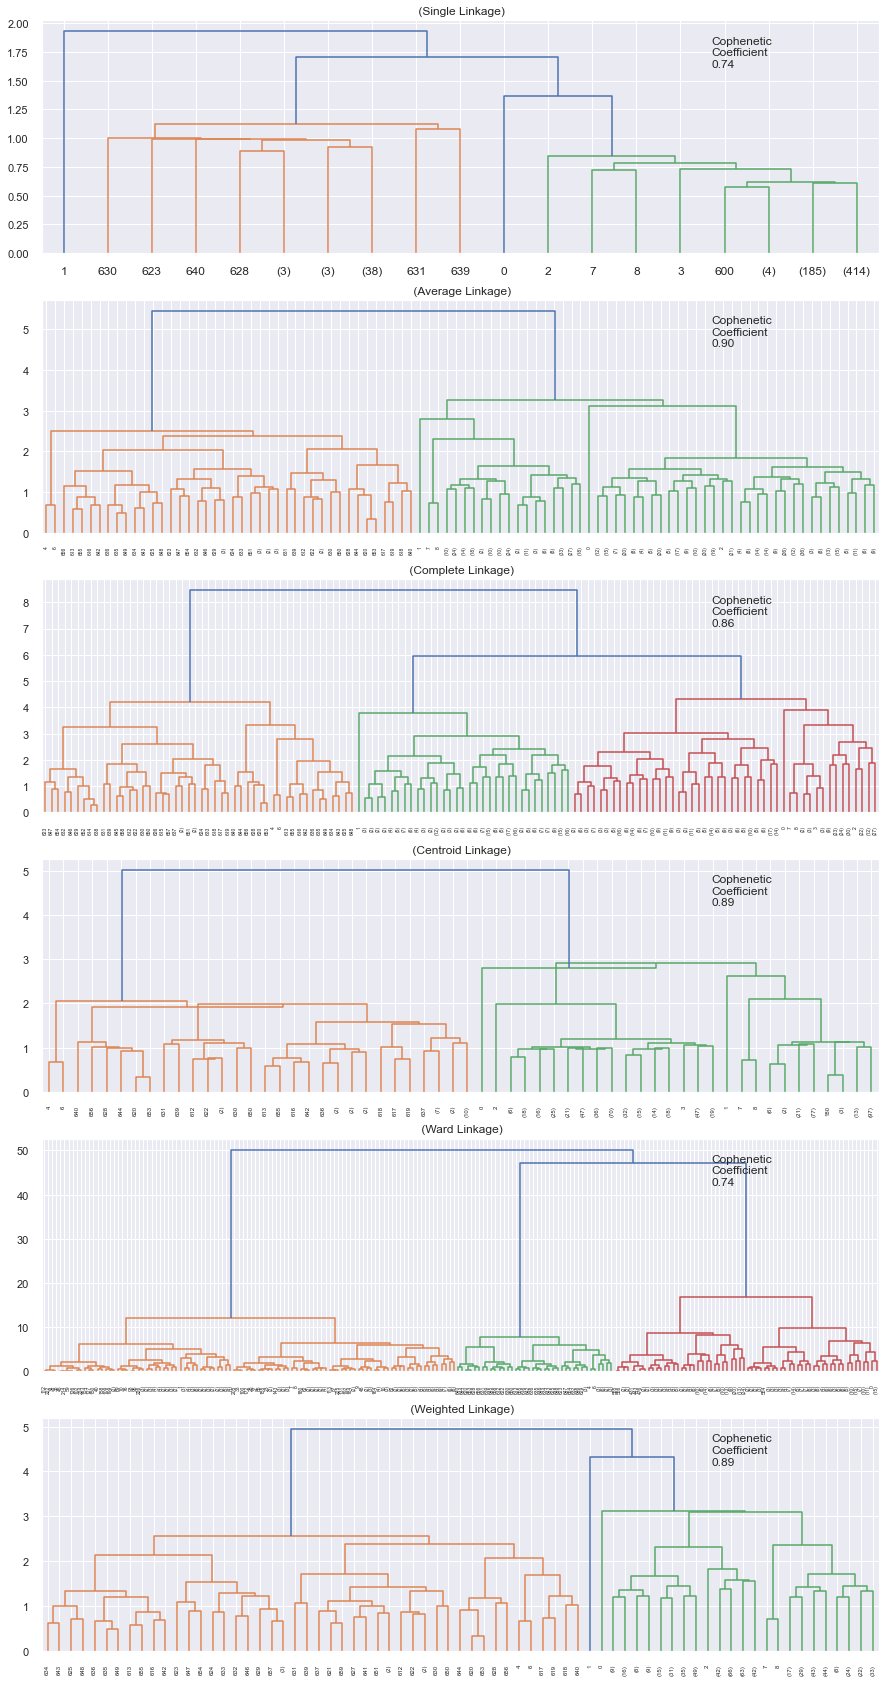

In [85]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward',
          'weighted']

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
#pw_distance = pdist(credit_scaled)

# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
# compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_scaled_df2, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i], truncate_mode='level', p=7);
    axs[i].set_title(f' ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df2))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
#     compare.append([method, coph_corr])

* Choose Ward Linkage

### Create cluster profile with k = 

In [95]:
#Trying with K value as 3
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='ward')
HCmodel.fit(subset_scaled_df2)
subset_scaled_df2['HC_Clusters'] = HCmodel.labels_

In [96]:
df2['HC_Clusters'] = HCmodel.labels_

In [97]:
cluster_profile2 = df2.groupby('HC_Clusters').mean()

In [98]:
cluster_profile2['count_in_each_segments'] = df2.groupby('HC_Clusters')['Total_Credit_Cards'].count().values

In [99]:
# lets display cluster profile
cluster_profile2.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,33851.948052,5.516883,3.493506,0.979221,1.994805,385
1,12151.111111,2.422222,0.937778,3.546667,6.857778,225
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


* Cluster 0 has the highest bank visits count and the lowest online visits count
* Cluster 1 has the highest phone calls count and the lowest credit limit and credit card count
* Cluster 2 has the highest credit limit, card count, and online visits, but the lowest bank visits and calls made counts

### Scaled Boxplots of numerical values in each cluster

IndexError: list index out of range

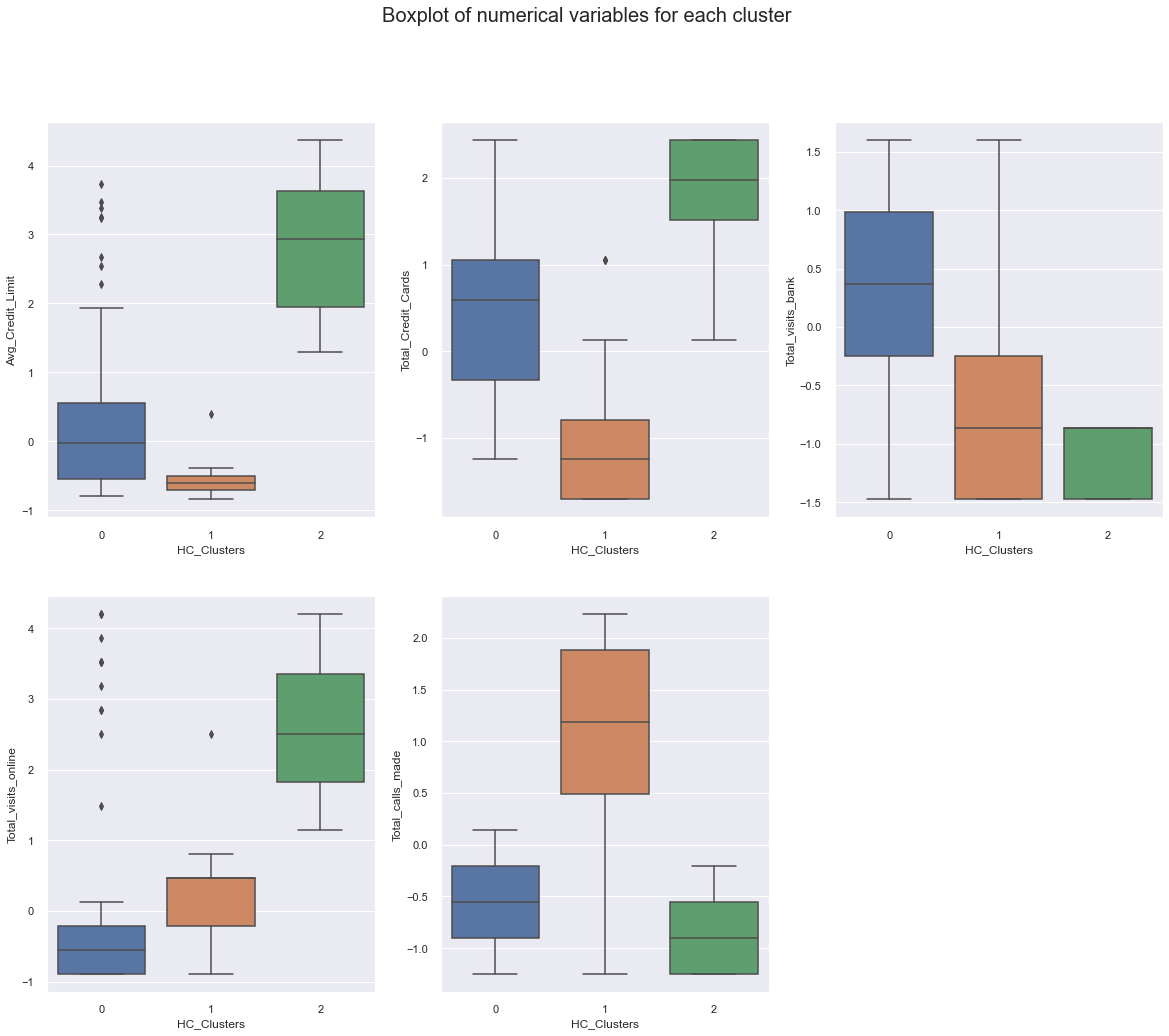

In [100]:
fig, axes = plt.subplots(2, 3,  figsize=(20, 16))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(2):
    sns.boxplot(ax=axes[ii][0],y=subset_scaled_df[all_col[counter]],x=subset_scaled_df2['HC_Clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][1],y=subset_scaled_df[all_col[counter]],x=subset_scaled_df2['HC_Clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][2],y=subset_scaled_df[all_col[counter]],x=subset_scaled_df2['HC_Clusters'])
    counter = counter+1
    
    fig.delaxes(ax= axes[1,-1]) 
    

fig.tight_layout(pad=2.0)

### Value Boxplots of numerical values in each cluster

IndexError: list index out of range

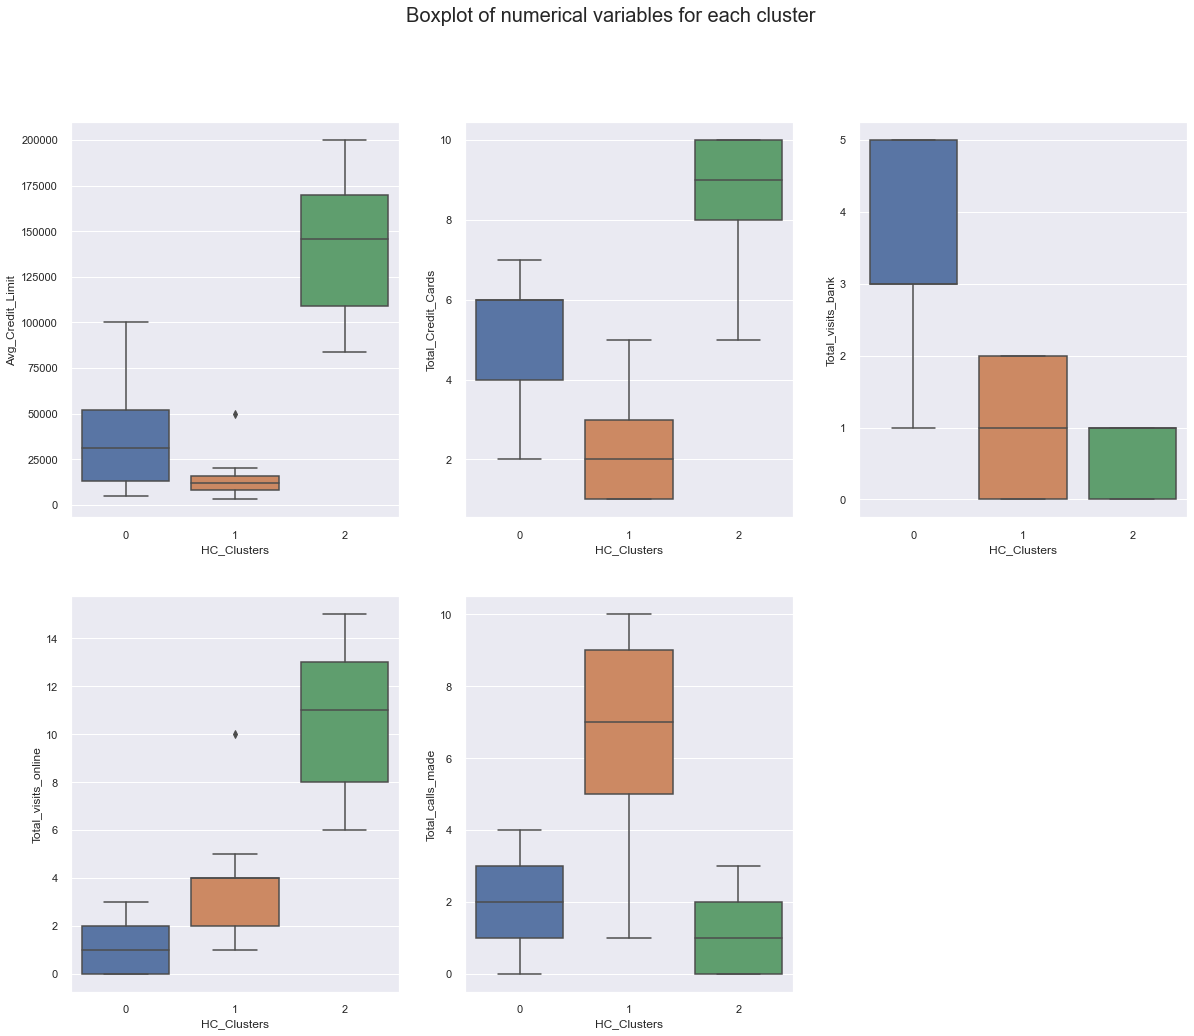

In [101]:
# data
fig, axes = plt.subplots(2, 3,  figsize=(20, 16))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(2):
    sns.boxplot(ax=axes[ii][0],y=df2[all_col[counter]],x=df2['HC_Clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][1],y=df2[all_col[counter]],x=df2['HC_Clusters'])
    counter = counter+1
    sns.boxplot(ax=axes[ii][2],y=df2[all_col[counter]],x=df2['HC_Clusters'])
    counter = counter+1
    
    fig.delaxes(ax= axes[1,-1]) 
    

fig.tight_layout(pad=2.0)

### Insights
- **Cluster 0**
   - The average credit limit is on the low end, close to 12.5K
   - The total number of credit cards is in the middle, around 2
   - This cluster had an average of one visit to the bank
   - About 3 online visits
   - The highest number of phone calls made with an average of 7

- **Cluster 1**
   - The average credit limit is close to 25K
   - The customers here also have an average of 5 credit cards
   - Between 4 and 5 visits to the bank, the most of all clusters
   - An average of 1 online visit
   - An average of 2 calls made

- **Cluster 2**
   - Highest credit limit at close to 150K
   - Highest number of credit cards, averagin 9
   - On average, 1 visit to the bank in a specified time frame
   - Highest online visits of 11 times average
   - Lowest avaerage phone calls of 1
   
- **Cluster 3**
   - The average credit limit is on the low end, close to 14K
   - Averages of 6 credit cards
   - At most, 3 visits to the bank
   - An average of 1 online visits
   - This cluster has an average of 2 phone calls made

- **Cluster 4**
   - The average credit limit is in the middle, close to 56K
   - Averages of 6 credit cards
   - In the middle, with around 2.5 visits to the bank
   - An average of 1 online visits
   - This cluster has an average of around 3 phone calls made



# Cluster method comparison (K-Means and HAC)

In [102]:
# 3 Clusters
cluster_profile.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,34071.428571,5.518519,3.484127,0.981481,1.992063,378
1,12239.819005,2.411765,0.945701,3.561086,6.891403,221
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [103]:
# 5 Clusters
cluster_profile2.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,33851.948052,5.516883,3.493506,0.979221,1.994805,385
1,12151.111111,2.422222,0.937778,3.546667,6.857778,225
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


## Insights

* Both methods produced identical clusters
* Both approaches had a minimum of 50 in one of the clusters
* There was one cluster in both of the methods that had the exact same values (cluster 2)
* Cluster 0 and 3 in HC did not contain any numbers larger than any of the other clusters. This could mean that their contents could assume a position in another cluster

# Recommendations

* The marketing team should look into streamlining the online services keeping in mind the customers with high credit limits and a larger amount of credit cards.  Ideas could include an automated representative to respond to basic queries (balances, payments, accounts, benefits, transfers, etc.). They could also update the online experience by re-evaluating the webpage layout, links, and have any basic queries addressed on an FAQ page.  Another feature could be a global view of all cards with their account information (balances, etc.) and facilitate ways to pay balances all at once.

* The Marketing department should look at improving the call center experience keeping in mind those customers who have the lowest credit limit and fewest number of cards.  With more data, we could discern why those with lower credit limit and cards prefer to use the call centers.  Regardless, their experience should be positive and should create a desire for the customer to continue banking with AllLife and using the credit cards.  Suggestions could include shortening wait times, allowing an option to have the query addressed through an automated responder, else an option to speak with a live representative.  Also, the customer could provide feedback after disconnecting so that the bank can continuously evaluate the quality of the service rendered.  As well, in order to increase usage or increase clientele, benefits or “perks” could be offered as part of the representatives “script” to potentially strengthen the customer’s loyalty to the AllLife brand.

* The Marketing department should also look at improving the in-person bank visits keeping in mind those that have moderate credit limits and an average number of cards by having kiosks established near the entrance so that customers could have a first line of addressing their queries before moving to a live representative. The bank could also have in-store displays for some of these customers to consider applying for a higher limit card with favorable introductory rates, or a different card based on usage (e.g., business, travel, etc.).  These would be avenues to consider which would inherently bring in revenue and potentially promote more product usage.
